# Module 3: Factor analysis

In this lab you will learn about **Factor Analysis** (FA),
which is a linear factor model that not only assumes observables are a linear combination of factors
(or latent variables) plus noise, but also that they follow Gaussian distribution.
In addition, observed variables are assumed to be conditionally independent, given latent variables.

Some key aspects to focus on:
+ Fewer factors than original features in data space.
+ Different types of methods and solutions.
+ More elaborate framework than principal component analysis.

For this session, we are going to use **red wine quality** dataset for factor analysis and
transform its data space into feature space with 5 factors.

sklearn API reference:

+ [sklearn.decomposition.FactorAnalysis](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html)

**Note:** Previously you saw Factor Analysis in the 8610 (Stat/Math) course.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import numpy as np
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import scale


## Load dataset

In [2]:
# Dataset location
DATASET = '/dsa/data/all_datasets/wine-quality/winequality-red.csv'
assert os.path.exists(DATASET)

# Load and shuffle
dataset = pd.read_csv(DATASET, sep=';').sample(frac = 1).reset_index(drop=True)

X = np.array(dataset.iloc[:, :-1])
y = np.array(dataset.quality)

dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [3]:
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.4,0.57,0.02,1.8,0.067,4.0,11.0,0.99700,3.46,0.68,9.5,5
1,7.2,0.41,0.30,2.1,0.083,35.0,72.0,0.99700,3.44,0.52,9.4,5
2,8.5,0.40,0.40,6.3,0.050,3.0,10.0,0.99566,3.28,0.56,12.0,4
3,5.9,0.55,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
4,8.9,0.62,0.19,3.9,0.170,51.0,148.0,0.99860,3.17,0.93,9.2,5


## Factor analysis with sklearn

In [4]:
fa = FactorAnalysis(n_components=5)
X_features = fa.fit_transform(X)
print('Features shape', X_features.shape)

Features shape (1599, 5)


## Estimation of the factor model

Factor analysis essentially proposes the following to explain the structure of the observables:

$$ X - \mu = LF + \varepsilon $$

+ L: Factor loadings
+ F: Features

That is to assume observables are a linear combination of latent variables plus noise.
And this is an estimation problem that usually takes some numerical computation to solve iteratively.

In practice, to solve factor analysis, the **goal** would be to find estimates of factor loadings **L** and specific variances **Ψ**, such that:

$$ cov(X) = LL^T + cov(\varepsilon) = LL^T + \Psi $$


### Factor loadings

The factor loadings is the matrix **L** would take latent variables and transform them to observables **X** minus its mean and noise.
The following cell prints one found by `sklearn`.

In [5]:
def FactorLoadings(components, n_components=5):
    """This functions puts a frame on the loadings matrix for prettified printing"""
    return pd.DataFrame(components.T,
        columns = ['Factor {}'.format(i+1) for i in range(n_components)],
        index = dataset.columns[:-1])

FactorLoadings(fa.components_, n_components=5)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
fixed acidity,-0.161692,-1.145026,0.525767,0.412258,0.964023
volatile acidity,0.013626,-0.005764,-0.041384,-0.011233,-0.072485
citric acid,0.007791,-0.065046,0.057872,0.058579,0.108214
residual sugar,0.306013,-0.417179,0.445379,0.131728,-0.280869
chlorides,0.002664,-0.009901,-0.004634,-0.002355,0.006367
free sulfur dioxide,7.338024,1.253900,4.149618,-5.979583,0.106642
total sulfur dioxide,32.795243,1.303346,-0.671834,1.656218,-0.013853
density,0.000209,-0.001862,0.000187,0.000068,-0.000032
pH,-0.011372,0.054082,0.005221,-0.020063,-0.117808
sulphates,0.008098,-0.020796,0.035236,0.015193,0.026729


### Specific variances

The specific variances matrix **Ψ** is a _diagonal matrix_ representing the variances of 
noise in the model with the following elements on the diagonal.

In [6]:
fa.noise_variance_

array([3.16564061e-01, 2.47304841e-02, 1.51411722e-02, 1.42437402e+00,
       2.04105829e-03, 9.41611024e-01, 1.00434986e+00, 9.56654549e-09,
       6.45761177e-03, 2.60298530e-02, 1.25044888e-02])

## Reconstruction of data space

The factor analysis models the observables **X** as a linear combination of factors plus noise.
Therefore, it should be insteresting to reconstruct data space with some solution appropiate for the formulation of factor analysis.

In [7]:
print('Factors shape', fa.components_.shape)
noise = np.random.multivariate_normal(np.mean(X, axis = 0), np.diag(fa.noise_variance_), X.shape[0])
X_reconstructed = np.dot(X_features, fa.components_) + noise
print('Reconstructed dataset shape', X_reconstructed.shape)

Factors shape (5, 11)
Reconstructed dataset shape (1599, 11)


The following cell shows a reconstructed dataset which is an approximation of original dataset.

In [8]:
pd.DataFrame(X_reconstructed, columns = dataset.columns[:-1]).head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,6.776808,0.846396,-0.129844,3.173322,0.074542,3.301255,9.108037,0.996920,3.447660,0.542601,9.387363
1,7.480911,0.534638,0.182529,3.453638,0.085344,34.652513,72.255414,0.996888,3.381060,0.571238,9.593378
2,8.637606,0.535013,0.406001,3.667917,0.089735,3.645886,10.948515,0.995374,3.352822,0.590940,12.131769
3,6.306170,0.393714,0.157660,1.266560,0.053674,37.230613,49.694294,0.994978,3.476273,0.810130,11.211939
4,8.796018,0.388657,0.213862,4.464326,0.046735,52.707766,149.105104,0.998647,3.289513,0.801718,9.141098


The following cell shows the original dataset for comparison.
They **could appear to be very different**, although still following some general pattern,
because random noise was just introduced,
but this aims to demonstrate the connection between data space and feature space.

In [9]:
dataset.iloc[:5, :-1]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,6.4,0.57,0.02,1.8,0.067,4.0,11.0,0.99700,3.46,0.68,9.5
1,7.2,0.41,0.30,2.1,0.083,35.0,72.0,0.99700,3.44,0.52,9.4
2,8.5,0.40,0.40,6.3,0.050,3.0,10.0,0.99566,3.28,0.56,12.0
3,5.9,0.55,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
4,8.9,0.62,0.19,3.9,0.170,51.0,148.0,0.99860,3.17,0.93,9.2


## Verify covariance structure of FA

A more meaningful thing to try than restructing data space could be verifying its covariance structure,
because unlike the previous example, we don't have to re-introduce noise which was lost during factor analysis.

In practice, a proper solution to FA is usually verfied by plugging into the claim 1 below.

### Claim 1:

$$ cov(X) = LL^T + \Psi $$

+ L: Factor loadings
+ Ψ: Specific variance / noise variance

In [10]:
X_centered = scale(X, with_std = False)

print(np.allclose(
    np.dot(X_centered.T, X_centered) / X.shape[0],                # left hand side: covariance matrix of X
    np.dot(fa.components_.T, fa.components_) + np.diag(fa.noise_variance_)   # right hand side
))

print(np.isclose(
    np.dot(X_centered.T, X_centered) / X.shape[0],                # left hand side: covariance matrix of X
    np.dot(fa.components_.T, fa.components_) + np.diag(fa.noise_variance_),  # right hand side
atol=1e-2, rtol=1e-1).astype('int'))

False
[[1 1 1 0 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1]
 [0 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]]


Although this factor analysis solution provided by sklearn wasn't very precise, it's still close and useful.

The following cell compares our calculations with those provided by numpy and sklearn packages.
It turns out that the computation of **left_hand_side** and **right_hand_side** are accurate to definition.

In [11]:
print(np.allclose(
    np.dot(X_centered.T, X_centered) / X.shape[0],                # left hand side: covariance matrix of X
    np.cov(X, rowvar = False, bias = True)                        # covariance matrix by numpy
))

print(np.allclose(
    np.dot(fa.components_.T, fa.components_) + np.diag(fa.noise_variance_),  # right hand side
    fa.get_covariance()                                           # covariance matrix by sklearn
))

True
True


### Claim 2:

$$ cov(X, F) = L$$ 

+ L: Factor loadings
+ F: Features

In [12]:
print(np.allclose(
    np.mean(X[..., np.newaxis] * np.expand_dims(X_features, 1), axis = 0), # left hand side
    fa.components_.T,                                                      # right hand side
rtol = 1e-3))

True


## The principal component solution

Factor analysis provides a latent linear model to explain the observables **x**, 
which serves as a valuable insight towards feature extraction.
However, different types of methods have been proposed for solving factor analysis, including the **principal component method** and the **maximum likelihood method**.

Now, we plug principal components into covariance structure of factor analysis
to verify this is one of its solutions. 
This also demonstrates the relation between FA and PCA.

### PCA transform

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
PCA_features = pca.fit_transform(X_centered)

### Verify claim 1

$$cov(X) = L L^T + \Psi$$

+ L: Factor loadings - provided by spectral decomposition
+ Ψ: Noise variance - set to 0 becaues PCA doesn't model noise

In [14]:
print(np.isclose(
    np.dot(X_centered.T, X_centered) / X.shape[0],      # left hand side: covariance matrix of X
    sum(eigenvalue*np.outer(eigenvector,eigenvector)    # right hand side: spectral decomposition
        for eigenvalue, eigenvector in zip(pca.explained_variance_, pca.components_)),
atol=1e-2, rtol=1e-1).astype('int'))

[[1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 1 1 1 1 1 1 1 1]
 [1 0 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1]]


Note: PCA could be considered a special case to FA.

## Factor loadings

The following is the factor loadings offered by PCA. This is a corollary from spectral decomposition in its additive form. 
Please refer to [_spectral decomposition_](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) for further information if interested.

$$cov(X)=\sum \lambda_i q_i q_i^T = LL^T $$

In [15]:
FactorLoadings(np.vstack([np.sqrt(eigenvalue)*eigenvector
    for eigenvalue, eigenvector in zip(pca.explained_variance_, pca.components_)]))

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
fixed acidity,-0.206493,-0.181912,1.678522,-0.357571,0.100396
volatile acidity,0.012946,-0.015297,-0.044258,0.009811,-0.042100
citric acid,0.005755,-0.023100,0.129804,-0.013262,0.042432
residual sugar,0.291228,0.084753,0.494703,1.272212,-0.180673
chlorides,0.002146,-0.001801,0.005188,-0.000870,-0.009697
free sulfur dioxide,7.369379,7.423268,0.036800,-0.028582,-0.008049
total sulfur dioxide,32.853093,-1.666292,-0.002689,-0.005368,0.010560
density,0.000125,-0.000190,0.001367,0.000074,-0.000853
pH,-0.009024,0.024904,-0.103251,0.027757,0.012911
sulphates,0.007522,0.004711,0.030863,-0.009711,0.024126


### Factor analysis vs principal component analysis

+ FA imposes a structure with fixed number of factors; PCA analyzes the eigenstructure of data and provides principal components in descreasing order of importance.
+ FA focuses on interpretation of data; PCA focuses on maximizing variances.
+ FA provides a model that needs estimation techniques to solve; PCA is a well-defined algorithm with unique solution.
+ FA and PCA both assume the linear structure of the data and utilize similar set of mathematical tools.

## Scree plot

This plots variances (y-axis) against components (x-axis).
It helps us to decide on number of principal components to be retained, although this is subjective.

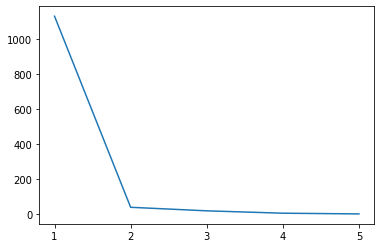

In [16]:
explained_variance = np.flip(np.sort(np.sum(fa.components_**2, axis=1)), axis=0)
x_ticks = np.arange(len(fa.components_))+1
plt.xticks(x_ticks) # this enforces integers on the x-axis
plt.plot(x_ticks, explained_variance)

Similarily, you could also plot the explained variance ratio.
FA should not have total explained variance ratio equal to 1 because of noise variance.

total expained variance ratio 0.9968474084854319


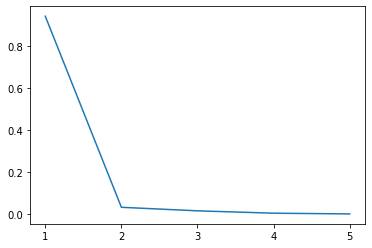

In [17]:
explained_variance_ratio = explained_variance/(np.sum(explained_variance)+np.sum(fa.noise_variance_))
plt.xticks(x_ticks) # this enforces integers on the x-axis
plt.plot(x_ticks, explained_variance_ratio)
print('total expained variance ratio', np.sum(explained_variance_ratio))

## Conclusion

In this lab we learned about:
+ Apply FA to a dataset for feature extraction.
+ Reconstruction of original dataset from FA.
+ Convariance structure of FA.
+ Comparing FA and PCA.
+ Scree plot of FA.